In [ ]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
import wandb 

from nerfstudio.models.nesf import TransformerModel
from nerfstudio.field_components.field_heads import FieldHeadNames
import os
from livelossplot import PlotLosses

os.environ['WANDB_NOTEBOOK_NAME'] = '/data/vision/polina/projects/wmh/dhollidt/documents/nerf/nerfstudio_fork/playground/identiy.ipynb'


In [1]:

# [1, seq, 3]

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = "cpu"

# Define the MLP model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        hidden_dim = 128
        self.fc1 = nn.Linear(3, hidden_dim)  # input size 3, output size 64
        self.fc2 = nn.Linear(hidden_dim, 3)  # input size 64, output size 3
        self.config = {
            "name": "MLP",
            "hidden_dim": hidden_dim,
        }
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        # x = torch.sigmoid(x)
        return x


class Transformer(nn.Module):
        def __init__(self,
                    dimension = 3,
                    num_layers = 1,
                    num_heads = 3,
                    dim_feed_forward = 128,
                    dropout_rate = 0.1,
                    activation = torch.relu,
                    ):
            super(Transformer, self).__init__()
            
            
            
            
            self.upscale = torch.nn.Linear(3, dimension)
            self.downscale = torch.nn.Linear(dimension, 3)
            self.transformer_model = TransformerModel(
                output_size=dimension,
                num_layers=num_layers,
                input_size=dimension,
                num_heads=num_heads,
                dim_feed_forward=dim_feed_forward,
                dropout_rate=dropout_rate,
                activation=activation,
                )
            self.config = {
                "name": "Transformer",
                "dimension": dimension,
                "num_layers": num_layers,
                "num_heads": num_heads,
                "dim_feed_forward": dim_feed_forward,
                "dropout_rate": dropout_rate,
                "activation": activation.__name__,
            }
            
        def forward(self, x):
            # print("1", x.shape)
            
            x = x.reshape(x.shape[0],-1, 3)
            # print("3", x.shape)
            
            x = torch.relu(self.upscale(x))
            # print("4", x.shape)
            
            x = self.transformer_model(x)[FieldHeadNames.SEMANTICS]
            # print("5", x.shape)
            
            x = torch.relu(self.downscale(x))
            # print("6", x.shape)

            x = x.reshape(x.shape[0], 32, 32, 3)
            # print("7", x.shape)
            
            return x

In [2]:
LIVE_PLOT = False



def train_sweep():
    wandb.init(project='my-first-sweep')
    config = wandb.config
    
    model = Transformer(
        dimension = config.dimension,
        num_layers = config.num_layers,
        num_heads = config.num_heads,
        dim_feed_forward = config.dim_feed_forward,
        dropout_rate = config.dropout_rate,
    )
    print("Train sweep with config: ", config)
    train(model)

def train(model):
    # print model parameter count
    print("Model para count: ", sum(p.numel() for p in model.parameters() if p.requires_grad), "\n\n\n")
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    scheduler = StepLR(optimizer, step_size=50000, gamma=0.5)

    # Generate some dummy data for training and testing

    transform = transforms.Compose(
        [transforms.ToTensor(),
        #  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

    classes = ('plane', 'car', 'bird', 'cat',
            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4)
    testloader = DataLoader(testset, batch_size=1, shuffle=False, num_workers=4)

    # first_batch = next(iter(testloader))
    # inputs, labels = first_batch
    # print(classes[labels.item()])
    # inputs = inputs.squeeze(0)
    # print(inputs)
    # inputs = inputs.permute(2, 1, 0)
    # plt.imshow(inputs)
    # plt.show()
    # print(inputs.shape)
    # inputs_reshaped = inputs.reshape(-1, 3)
    # print(inputs_reshaped.shape)
    # inputs_back_reshaped = inputs_reshaped.reshape(32, 32, 3)
    # print(inputs_back_reshaped.shape)
    # plt.imshow(inputs_back_reshaped)
    # plt.show()


    # Train the model
    num_epochs = 10
    num_steps = 4000
    step = 0
    losses = []
    model = model.to(device)
    if LIVE_PLOT:
        liveloss = PlotLosses()

    for epoch in range(num_epochs):
        for i, data in enumerate(trainloader, 0):
            step += 1
            inputs, labels = data
            inputs = inputs.to(device)
            inputs = inputs.permute(0, 3, 2, 1)

            if isinstance(model, TransformerModel):
                outputs = model(inputs)[FieldHeadNames.SEMANTICS].squeeze(0)
            elif isinstance(model, Transformer):
                outputs = model(inputs)
                image_pred = outputs.detach().to('cpu').numpy()
            else:
                inputs = inputs.reshape(-1, 3)
                # Forward pass
                outputs = model(inputs)
                
            loss = nn.MSELoss()(outputs, inputs)
            
            # Backward pass and update weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # scheduler.step()
            
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{step}/{num_steps}] Loss: {loss.item():.4f}, LR: {scheduler.get_last_lr()[0]:.5f}',  end='\r')
            losses.append(loss.item())
            logs = {"loss": loss.item(), 
                    "lr": scheduler.get_last_lr()[0]
                    }
            wandb.log(logs)
            
            if (step+1) % 5 == 0:
                if LIVE_PLOT:
                    liveloss.update(logs)
                    liveloss.send()
                    
            if step >= num_steps:
                break
        if step >= num_steps:
                break

    print("\nFinished training")
    # plot the loss curve
    x = np.arange(len(losses))
    plt.plot(x, losses)
    plt.show()
    images_merged = []
    # Evaluate the model on test data
    with torch.no_grad():
        for i, data in enumerate(testloader, 0):
            if i >= 5:
                break
            inputs, labels = data
            inputs = inputs.to(device)
            inputs = inputs.permute(0, 3, 2, 1)
            
            if isinstance(model, TransformerModel):

                inputs = inputs.reshape(batch_size, -1, 3)
                test_outputs = model(inputs)[FieldHeadNames.SEMANTICS].squeeze(0)
                image_pred = test_outputs.reshape(32, 32, 3).to('cpu').numpy()
            elif isinstance(model, Transformer):
                print("1e", inputs.shape)
                test_outputs = model(inputs)
                image_pred = test_outputs.detach().to('cpu').squeeze(0).numpy()
            else:
                inputs = inputs.squeeze(0)
                
                inputs = inputs.reshape(-1, 3)
                
                test_outputs = model(inputs)
                image_pred = test_outputs.reshape(32, 32, 3).to('cpu').numpy()

                
            test_loss = nn.MSELoss()(test_outputs, inputs)
            print(f'Test Loss: {test_loss.item():.4f}')
            image_orig = inputs.reshape(32, 32, 3).to('cpu').numpy()
            # plot image with matplotlib
            print("1", image_pred.shape)
            print("2", image_orig.shape)
            image_merged = np.concatenate((image_pred, image_orig), axis = 1)
            
            images_merged.append(image_merged)
            plt.imshow(image_merged)
            plt.show()
            image_merged = wandb.Image(image_merged)

            wandb.log({"test_images": image_merged})


In [ ]:
# Create the model and optimizer
# model = MLP()
# model = nn.Sequential(
#             nn.Linear(3, 128),
#             nn.Linear(128, 3),
#         )
# model = TransformerModel(
#             output_size=3,
#             num_layers=6,
#             input_size=3,
#             num_heads=3,
#             dim_feed_forward=90,
#             dropout_rate=0.1,
#             activation=torch.relu,
#         )
model = Transformer()

wandb.init(
    project="identity",
    config=model.config
)
wandb.watch(model, log="all", log_freq=100)
train(model)

wandb.finish()            


In [3]:
sweep_configuration = {
    'method': 'random',
    'metric': {'goal': 'minimize', 'name': 'loss'},
    'parameters': 
    {
        'dimension': {'values': [4,8,16,32,64,128]},
        'num_layers': {'values': [1,2,3,4,5,6]},
        'num_heads': {'values': [1,2,4]},
        'dim_feed_forward': {'values': [4,8,16,32,64,128,256,512]},
        'dropout_rate':{'max': 0.5, 'min': 0.0},
     }
}
# 3: Start the sweep
sweep_id = wandb.sweep(sweep=sweep_configuration, project='identity')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Create sweep with ID: 4lfdc52o
Sweep URL: https://wandb.ai/dhollidt/identity/sweeps/4lfdc52o


wandb: Agent Starting Run: j9s27r3h with config:
wandb: 	dim_feed_forward: 32
wandb: 	dimension: 64
wandb: 	dropout_rate: 0.03856270500924186
wandb: 	num_heads: 4
wandb: 	num_layers: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: dominik-hollidt (dhollidt). Use `wandb login --relogin` to force relogin
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Train sweep with config:  {'dim_feed_forward': 32, 'dimension': 64, 'dropout_rate': 0.03856270500924186, 'num_heads': 4, 'num_layers': 3}
Model para count:  88963 



Files already downloaded and verified
Files already downloaded and verified
Epoch [1/10], Step [4000/4000] Loss: 0.0000, LR: 0.00100
Finished training


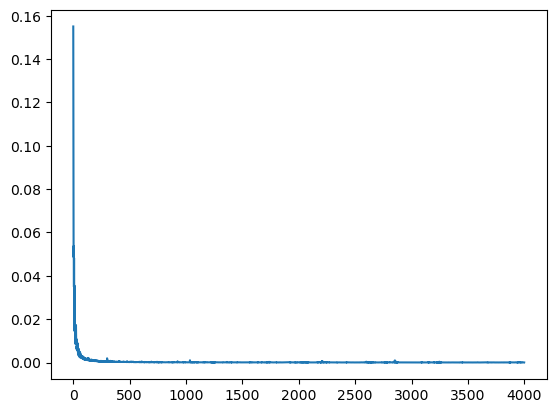

1e torch.Size([1, 32, 32, 3])
Test Loss: 0.0000
1 (32, 32, 3)
2 (32, 32, 3)


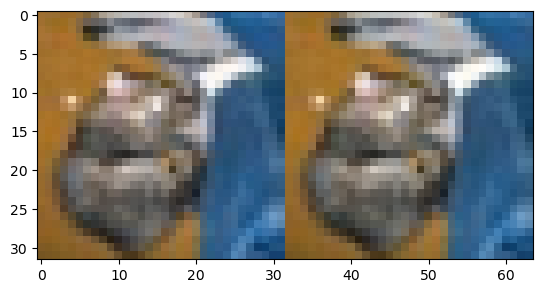

1e torch.Size([1, 32, 32, 3])
Test Loss: 0.0000
1 (32, 32, 3)
2 (32, 32, 3)


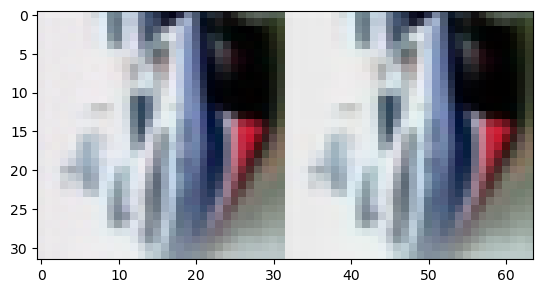

1e torch.Size([1, 32, 32, 3])
Test Loss: 0.0000
1 (32, 32, 3)
2 (32, 32, 3)


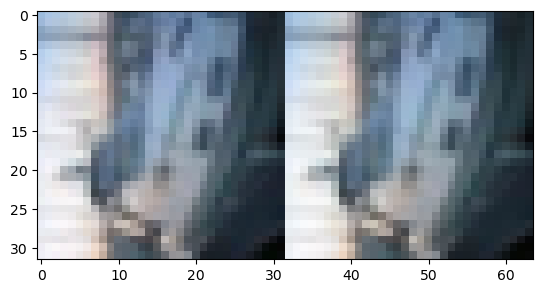

1e torch.Size([1, 32, 32, 3])
Test Loss: 0.0000
1 (32, 32, 3)
2 (32, 32, 3)


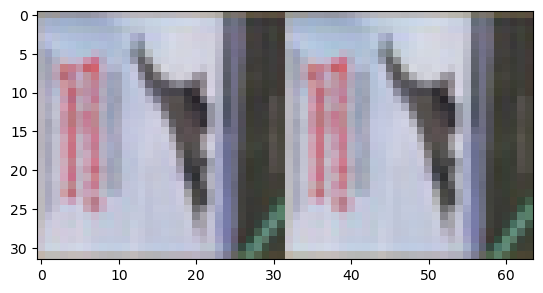

1e torch.Size([1, 32, 32, 3])
Test Loss: 0.0000
1 (32, 32, 3)
2 (32, 32, 3)


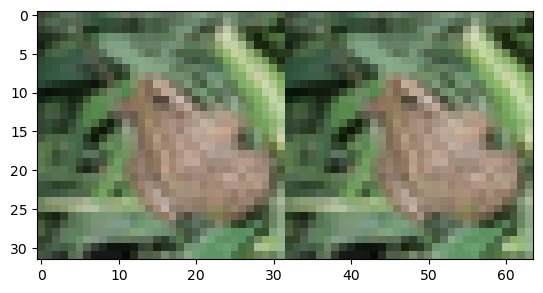

loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,3e-05
lr,0.001


wandb: Agent Starting Run: zx04vbx2 with config:
wandb: 	dim_feed_forward: 128
wandb: 	dimension: 32
wandb: 	dropout_rate: 0.46756726533905074
wandb: 	num_heads: 1
wandb: 	num_layers: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Train sweep with config:  {'dim_feed_forward': 128, 'dimension': 32, 'dropout_rate': 0.46756726533905074, 'num_heads': 1, 'num_layers': 2}
Model para count:  39395 



Files already downloaded and verified
Files already downloaded and verified
Epoch [1/10], Step [4000/4000] Loss: 0.0759, LR: 0.00100
Finished training


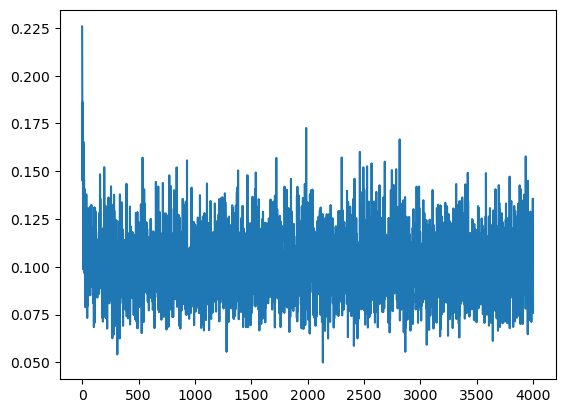

1e torch.Size([1, 32, 32, 3])
Test Loss: 0.0762
1 (32, 32, 3)
2 (32, 32, 3)


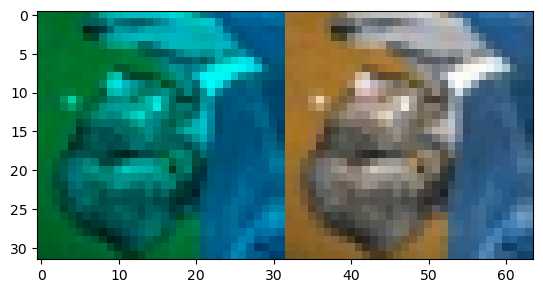

1e torch.Size([1, 32, 32, 3])
Test Loss: 0.1475
1 (32, 32, 3)
2 (32, 32, 3)


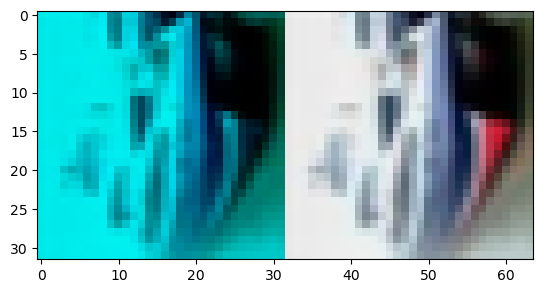

1e torch.Size([1, 32, 32, 3])
Test Loss: 0.0986
1 (32, 32, 3)
2 (32, 32, 3)


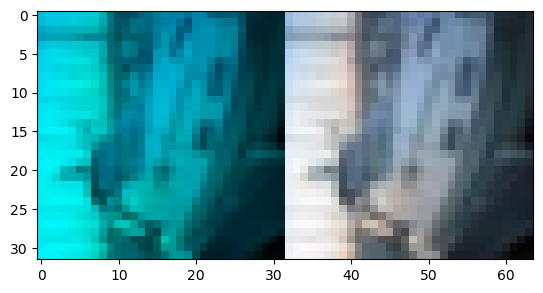

1e torch.Size([1, 32, 32, 3])
Test Loss: 0.1330
1 (32, 32, 3)
2 (32, 32, 3)


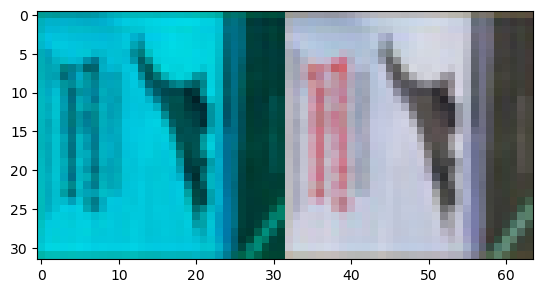

1e torch.Size([1, 32, 32, 3])
Test Loss: 0.0700
1 (32, 32, 3)
2 (32, 32, 3)


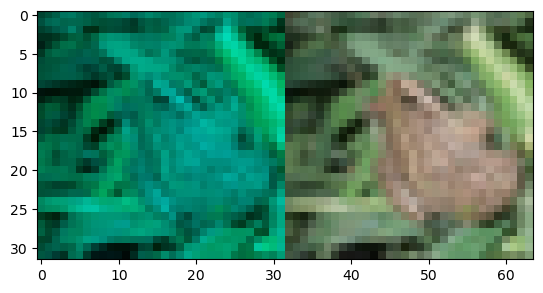

loss,▄▃▂▃▃▃▂▂▂▂▂▂▃▃▃▅▄▃▃▃▄▄▃▂█▅▂▃▃▄▂▄▁▂▄▂▁▄▃▂
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,0.07588
lr,0.001


wandb: Agent Starting Run: l1vkdo8b with config:
wandb: 	dim_feed_forward: 4
wandb: 	dimension: 64
wandb: 	dropout_rate: 0.2095886621710533
wandb: 	num_heads: 2
wandb: 	num_layers: 6
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Train sweep with config:  {'dim_feed_forward': 4, 'dimension': 64, 'dropout_rate': 0.2095886621710533, 'num_heads': 2, 'num_layers': 6}
Model para count:  126943 



Files already downloaded and verified
Files already downloaded and verified
Epoch [1/10], Step [4000/4000] Loss: 0.0000, LR: 0.00100
Finished training


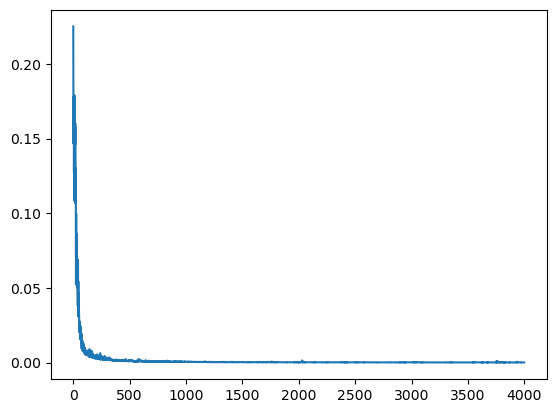

1e torch.Size([1, 32, 32, 3])
Test Loss: 0.0000
1 (32, 32, 3)
2 (32, 32, 3)


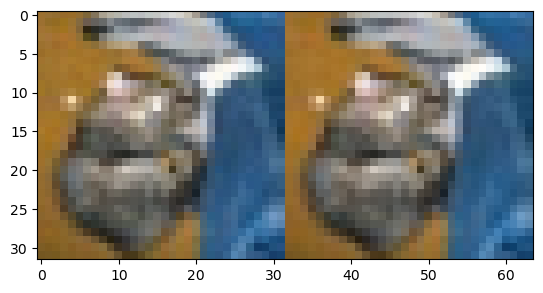

1e torch.Size([1, 32, 32, 3])
Test Loss: 0.0001
1 (32, 32, 3)
2 (32, 32, 3)


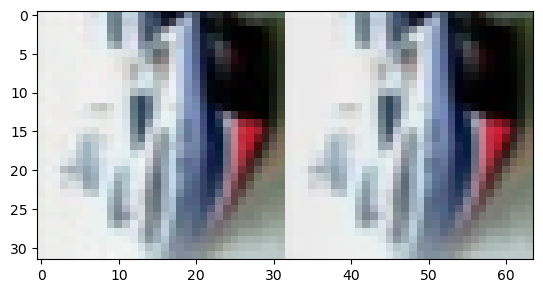

1e torch.Size([1, 32, 32, 3])
Test Loss: 0.0000
1 (32, 32, 3)
2 (32, 32, 3)


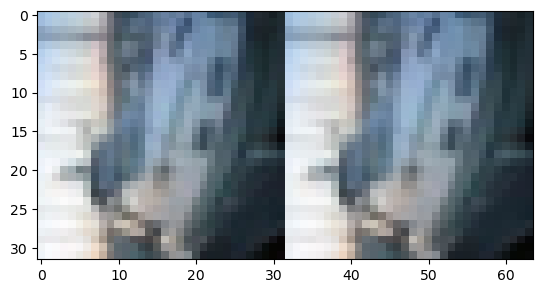

1e torch.Size([1, 32, 32, 3])
Test Loss: 0.0000
1 (32, 32, 3)
2 (32, 32, 3)


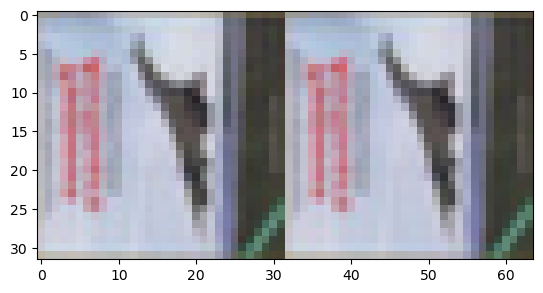

1e torch.Size([1, 32, 32, 3])
Test Loss: 0.0000
1 (32, 32, 3)
2 (32, 32, 3)


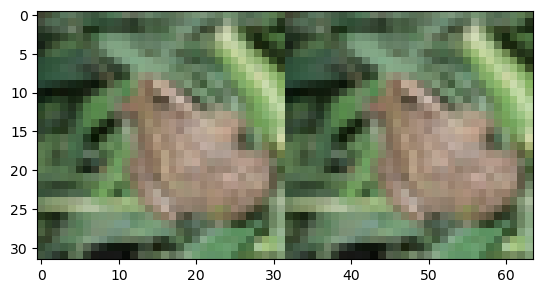

loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,5e-05
lr,0.001


wandb: Agent Starting Run: ugpqkqn1 with config:
wandb: 	dim_feed_forward: 256
wandb: 	dimension: 32
wandb: 	dropout_rate: 0.24724687676865464
wandb: 	num_heads: 1
wandb: 	num_layers: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Train sweep with config:  {'dim_feed_forward': 256, 'dimension': 32, 'dropout_rate': 0.24724687676865464, 'num_heads': 1, 'num_layers': 3}
Model para count:  85379 



Files already downloaded and verified
Files already downloaded and verified
Epoch [1/10], Step [4000/4000] Loss: 0.0000, LR: 0.00100
Finished training


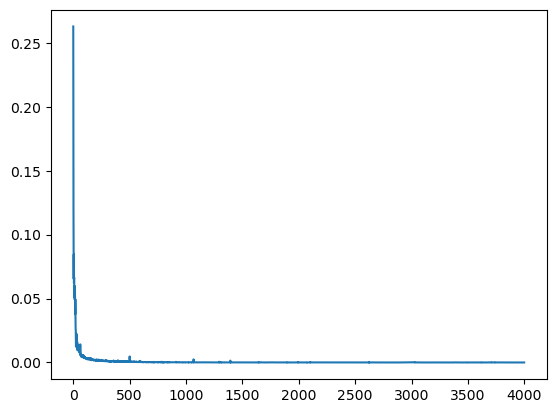

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1e torch.Size([1, 32, 32, 3])
Test Loss: 0.0000
1 (32, 32, 3)
2 (32, 32, 3)


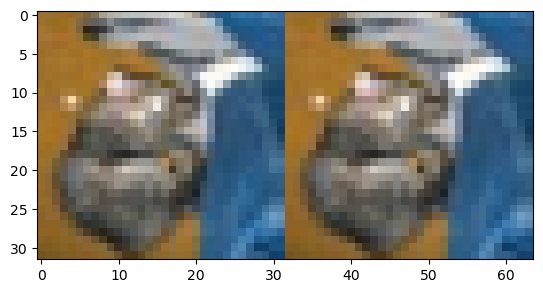

1e torch.Size([1, 32, 32, 3])
Test Loss: 0.0000
1 (32, 32, 3)
2 (32, 32, 3)


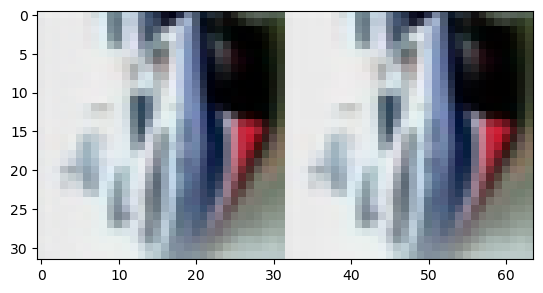

1e torch.Size([1, 32, 32, 3])
Test Loss: 0.0000
1 (32, 32, 3)
2 (32, 32, 3)


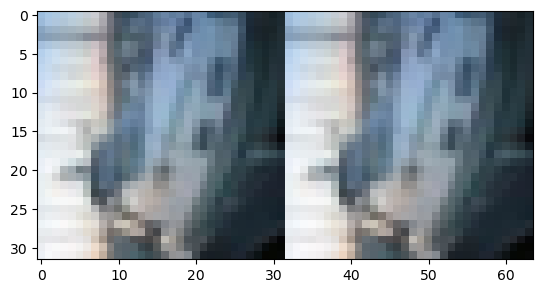

1e torch.Size([1, 32, 32, 3])
Test Loss: 0.0000
1 (32, 32, 3)
2 (32, 32, 3)


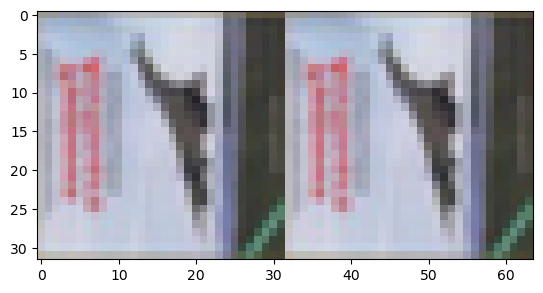

1e torch.Size([1, 32, 32, 3])
Test Loss: 0.0000
1 (32, 32, 3)
2 (32, 32, 3)


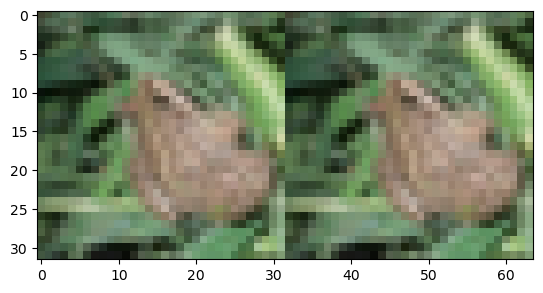

loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,1e-05
lr,0.001


wandb: Agent Starting Run: 3ou9gi03 with config:
wandb: 	dim_feed_forward: 256
wandb: 	dimension: 32
wandb: 	dropout_rate: 0.2891429913993705
wandb: 	num_heads: 2
wandb: 	num_layers: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Train sweep with config:  {'dim_feed_forward': 256, 'dimension': 32, 'dropout_rate': 0.2891429913993705, 'num_heads': 2, 'num_layers': 2}
Model para count:  64355 



Files already downloaded and verified
Files already downloaded and verified
Epoch [1/10], Step [4000/4000] Loss: 0.0000, LR: 0.00100
Finished training


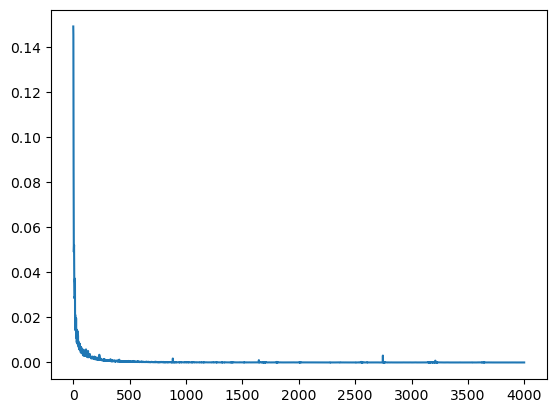

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1e torch.Size([1, 32, 32, 3])
Test Loss: 0.0000
1 (32, 32, 3)
2 (32, 32, 3)


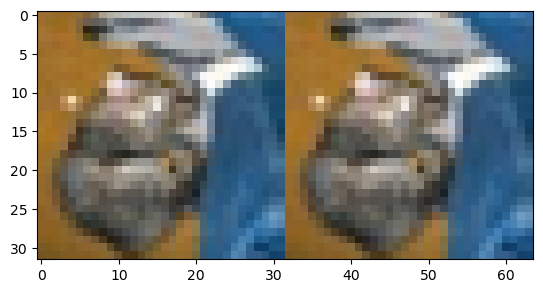

1e torch.Size([1, 32, 32, 3])
Test Loss: 0.0000
1 (32, 32, 3)
2 (32, 32, 3)


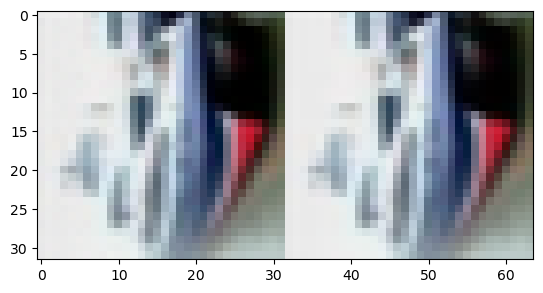

1e torch.Size([1, 32, 32, 3])
Test Loss: 0.0000
1 (32, 32, 3)
2 (32, 32, 3)


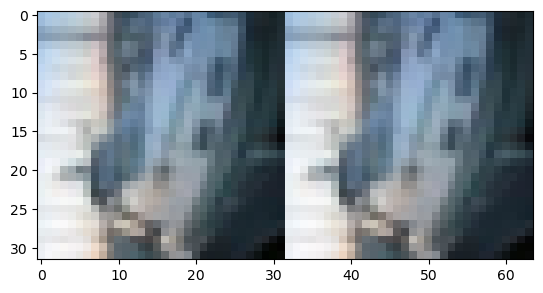

1e torch.Size([1, 32, 32, 3])
Test Loss: 0.0000
1 (32, 32, 3)
2 (32, 32, 3)


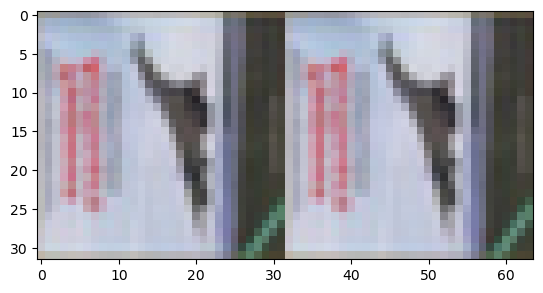

1e torch.Size([1, 32, 32, 3])
Test Loss: 0.0000
1 (32, 32, 3)
2 (32, 32, 3)


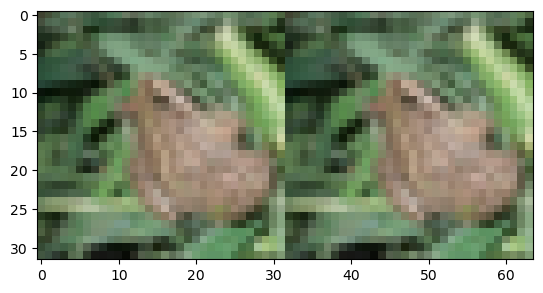

loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,1e-05
lr,0.001


wandb: Agent Starting Run: c7mnhffq with config:
wandb: 	dim_feed_forward: 4
wandb: 	dimension: 8
wandb: 	dropout_rate: 0.3120610161940763
wandb: 	num_heads: 2
wandb: 	num_layers: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Train sweep with config:  {'dim_feed_forward': 4, 'dimension': 8, 'dropout_rate': 0.3120610161940763, 'num_heads': 2, 'num_layers': 2}
Model para count:  1319 



Files already downloaded and verified
Files already downloaded and verified
Epoch [1/10], Step [4000/4000] Loss: 0.0799, LR: 0.00100
Finished training


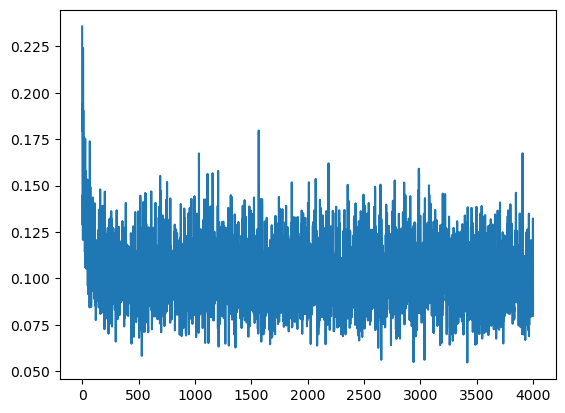

1e torch.Size([1, 32, 32, 3])
Test Loss: 0.0763
1 (32, 32, 3)
2 (32, 32, 3)


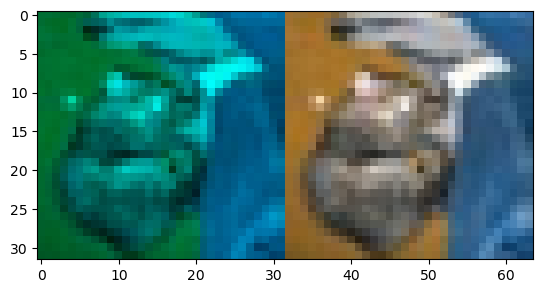

1e torch.Size([1, 32, 32, 3])
Test Loss: 0.1475
1 (32, 32, 3)
2 (32, 32, 3)


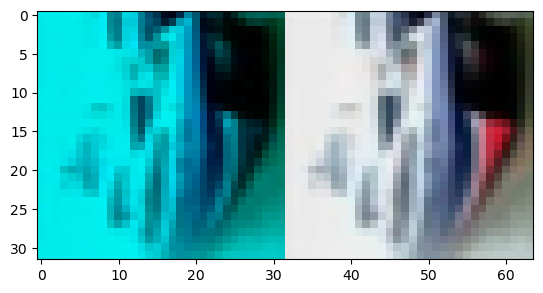

1e torch.Size([1, 32, 32, 3])
Test Loss: 0.0987
1 (32, 32, 3)
2 (32, 32, 3)


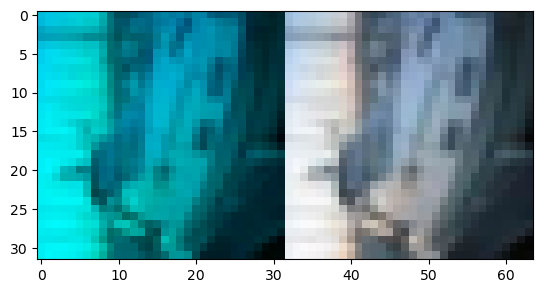

1e torch.Size([1, 32, 32, 3])
Test Loss: 0.1330
1 (32, 32, 3)
2 (32, 32, 3)


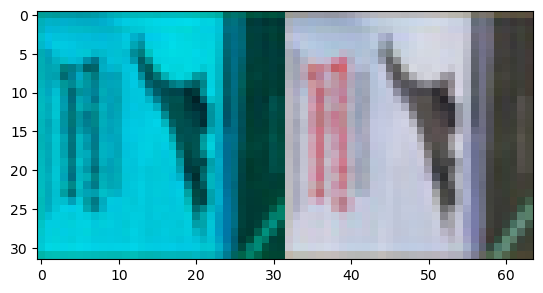

1e torch.Size([1, 32, 32, 3])
Test Loss: 0.0701
1 (32, 32, 3)
2 (32, 32, 3)


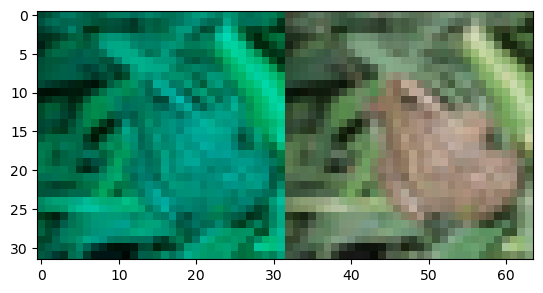

loss,█▆▁▆▅▂▃▂▂▆▄▃▄▆▄▄▅▂▄▂▄▄▃▅▂▄▄▇▂▅▅▄▂▅▄▄▄▄▁▄
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,0.07994
lr,0.001


wandb: Agent Starting Run: mfsj7g4m with config:
wandb: 	dim_feed_forward: 256
wandb: 	dimension: 32
wandb: 	dropout_rate: 0.3065471530792083
wandb: 	num_heads: 2
wandb: 	num_layers: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Train sweep with config:  {'dim_feed_forward': 256, 'dimension': 32, 'dropout_rate': 0.3065471530792083, 'num_heads': 2, 'num_layers': 1}
Model para count:  43331 



Files already downloaded and verified
Files already downloaded and verified
Epoch [1/10], Step [4000/4000] Loss: 0.0000, LR: 0.00100
Finished training


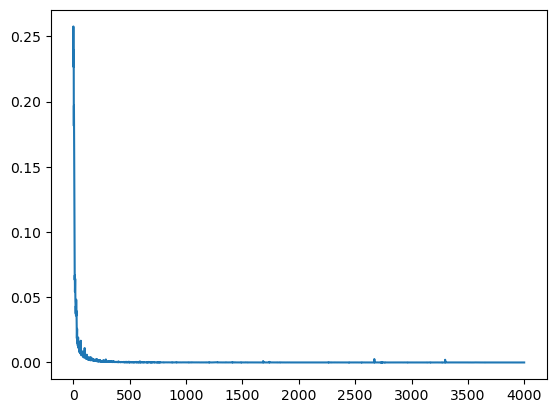

1e torch.Size([1, 32, 32, 3])
Test Loss: 0.0000
1 (32, 32, 3)
2 (32, 32, 3)


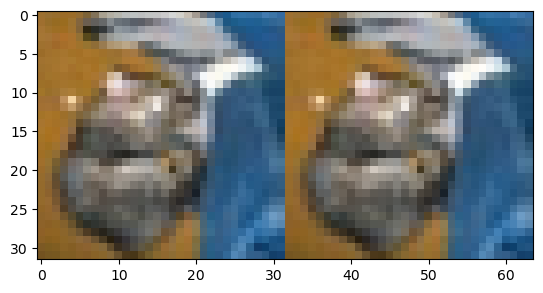

1e torch.Size([1, 32, 32, 3])
Test Loss: 0.0000
1 (32, 32, 3)
2 (32, 32, 3)


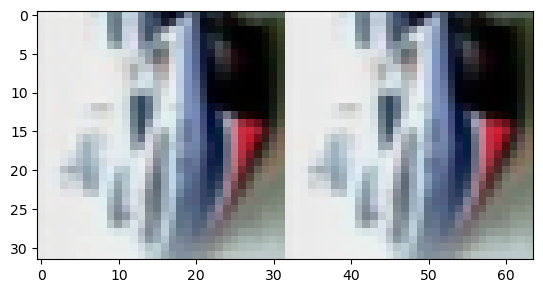

1e torch.Size([1, 32, 32, 3])
Test Loss: 0.0000
1 (32, 32, 3)
2 (32, 32, 3)


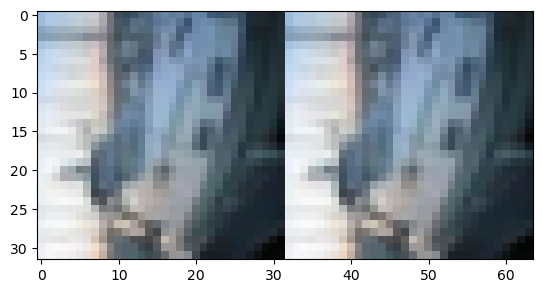

1e torch.Size([1, 32, 32, 3])
Test Loss: 0.0000
1 (32, 32, 3)
2 (32, 32, 3)


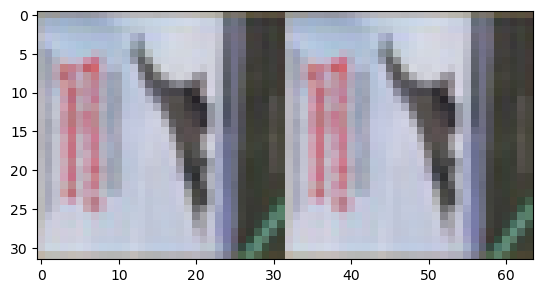

1e torch.Size([1, 32, 32, 3])
Test Loss: 0.0000
1 (32, 32, 3)
2 (32, 32, 3)


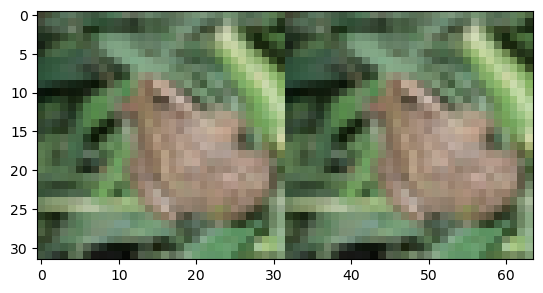

loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,1e-05
lr,0.001


wandb: Agent Starting Run: d655wqyg with config:
wandb: 	dim_feed_forward: 16
wandb: 	dimension: 8
wandb: 	dropout_rate: 0.2033190058498925
wandb: 	num_heads: 1
wandb: 	num_layers: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Train sweep with config:  {'dim_feed_forward': 16, 'dimension': 8, 'dropout_rate': 0.2033190058498925, 'num_heads': 1, 'num_layers': 1}
Model para count:  1331 



Files already downloaded and verified
Files already downloaded and verified
Epoch [1/10], Step [4000/4000] Loss: 0.0000, LR: 0.00100
Finished training


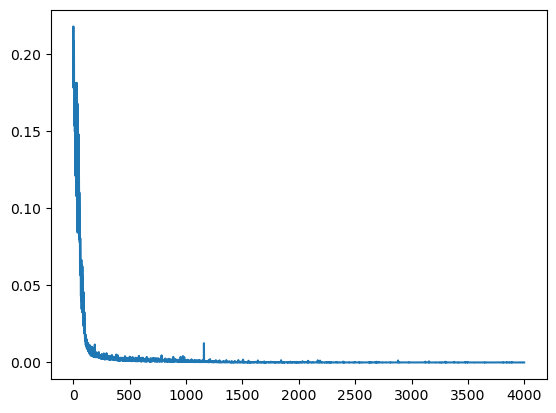

1e torch.Size([1, 32, 32, 3])
Test Loss: 0.0000
1 (32, 32, 3)
2 (32, 32, 3)


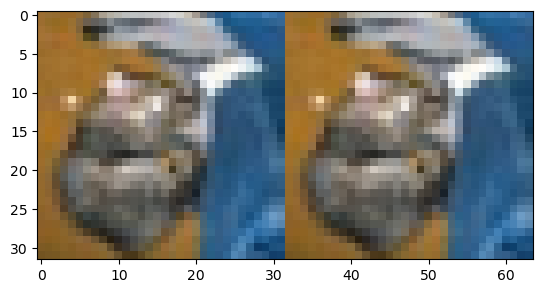

1e torch.Size([1, 32, 32, 3])
Test Loss: 0.0000
1 (32, 32, 3)
2 (32, 32, 3)


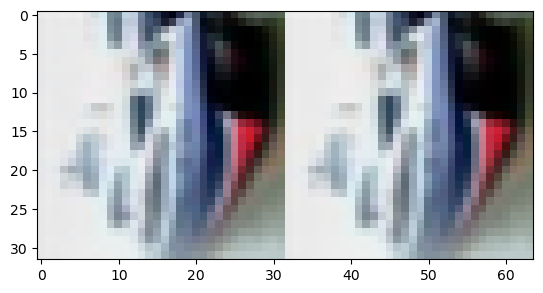

1e torch.Size([1, 32, 32, 3])
Test Loss: 0.0000
1 (32, 32, 3)
2 (32, 32, 3)


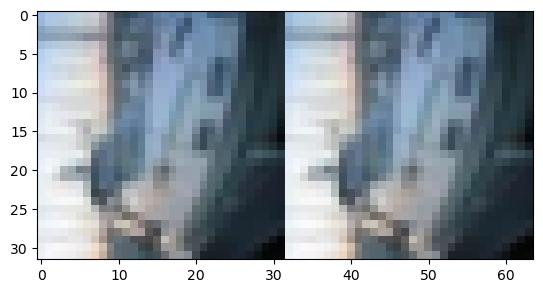

1e torch.Size([1, 32, 32, 3])
Test Loss: 0.0000
1 (32, 32, 3)
2 (32, 32, 3)


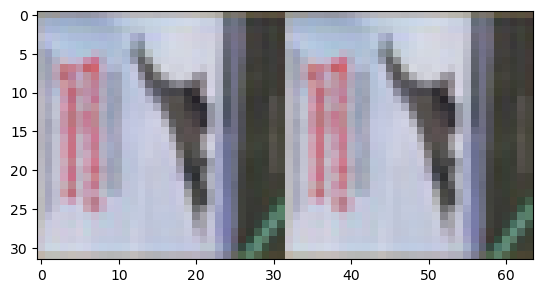

1e torch.Size([1, 32, 32, 3])
Test Loss: 0.0000
1 (32, 32, 3)
2 (32, 32, 3)


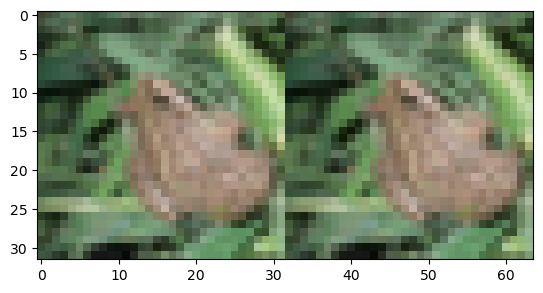

loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,1e-05
lr,0.001


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: l2j4he37 with config:
wandb: 	dim_feed_forward: 512
wandb: 	dimension: 16
wandb: 	dropout_rate: 0.19365307391444112
wandb: 	num_heads: 4
wandb: 	num_layers: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Train sweep with config:  {'dim_feed_forward': 512, 'dimension': 16, 'dropout_rate': 0.19365307391444112, 'num_heads': 4, 'num_layers': 1}
Model para count:  36515 



Files already downloaded and verified
Files already downloaded and verified
Epoch [1/10], Step [4000/4000] Loss: 0.0000, LR: 0.00100
Finished training


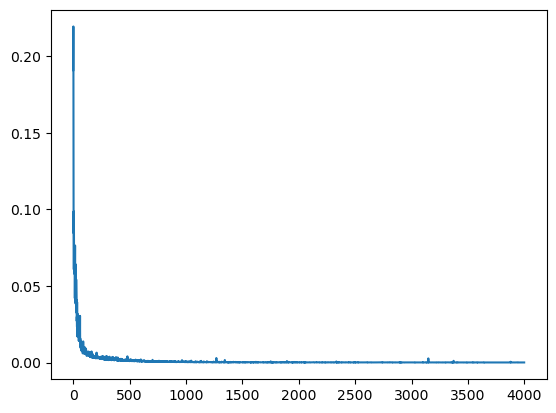

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1e torch.Size([1, 32, 32, 3])
Test Loss: 0.0000
1 (32, 32, 3)
2 (32, 32, 3)


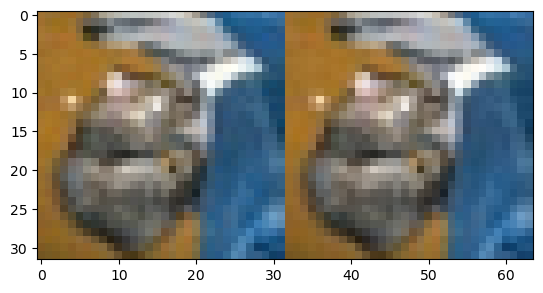

1e torch.Size([1, 32, 32, 3])
Test Loss: 0.0000
1 (32, 32, 3)
2 (32, 32, 3)


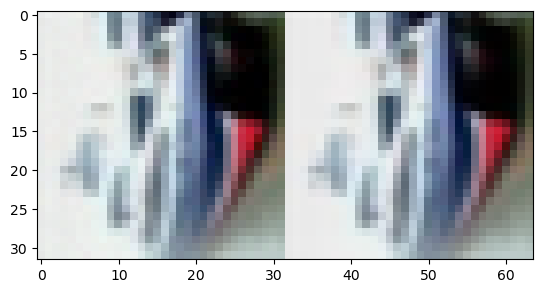

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1e torch.Size([1, 32, 32, 3])
Test Loss: 0.0000
1 (32, 32, 3)
2 (32, 32, 3)


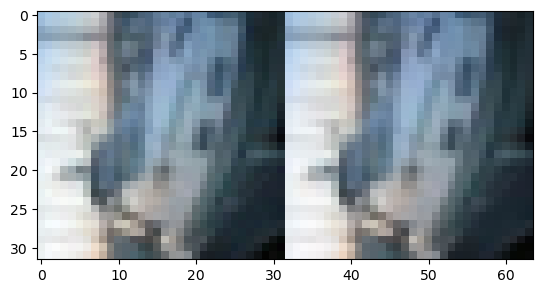

1e torch.Size([1, 32, 32, 3])
Test Loss: 0.0000
1 (32, 32, 3)
2 (32, 32, 3)


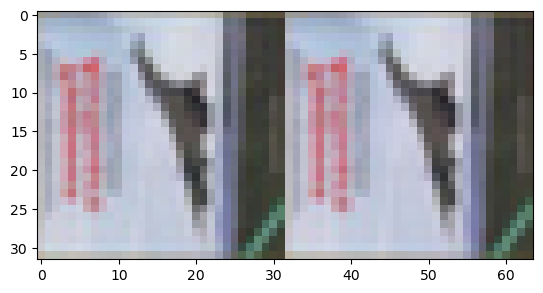

1e torch.Size([1, 32, 32, 3])
Test Loss: 0.0000
1 (32, 32, 3)
2 (32, 32, 3)


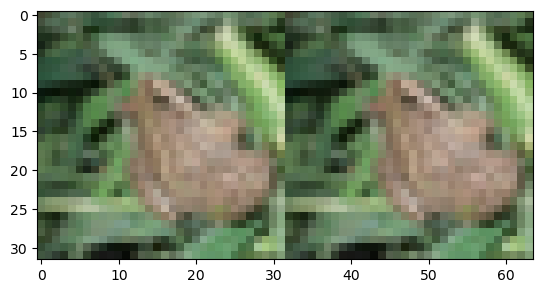

loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,4e-05
lr,0.001


wandb: Agent Starting Run: 7ec45gmf with config:
wandb: 	dim_feed_forward: 16
wandb: 	dimension: 32
wandb: 	dropout_rate: 0.29171662069688825
wandb: 	num_heads: 4
wandb: 	num_layers: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Train sweep with config:  {'dim_feed_forward': 16, 'dimension': 32, 'dropout_rate': 0.29171662069688825, 'num_heads': 4, 'num_layers': 2}
Model para count:  17555 



Files already downloaded and verified
Files already downloaded and verified
Epoch [1/10], Step [4000/4000] Loss: 0.0994, LR: 0.00100
Finished training


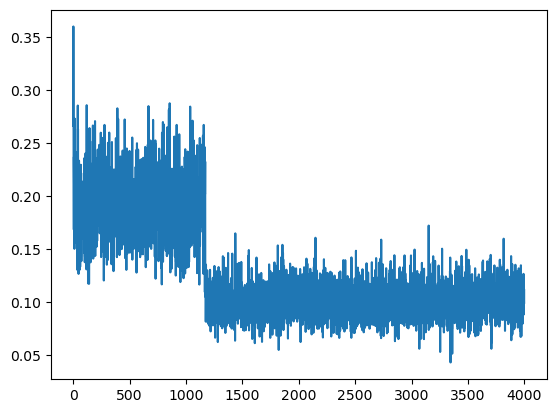

1e torch.Size([1, 32, 32, 3])
Test Loss: 0.0763
1 (32, 32, 3)
2 (32, 32, 3)


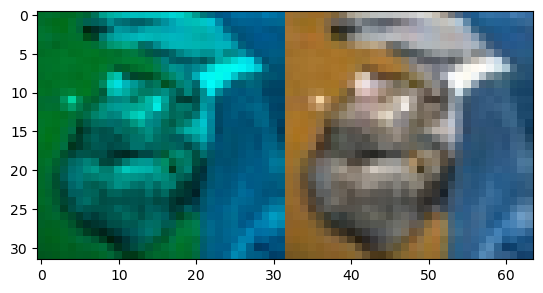

1e torch.Size([1, 32, 32, 3])
Test Loss: 0.1475
1 (32, 32, 3)
2 (32, 32, 3)


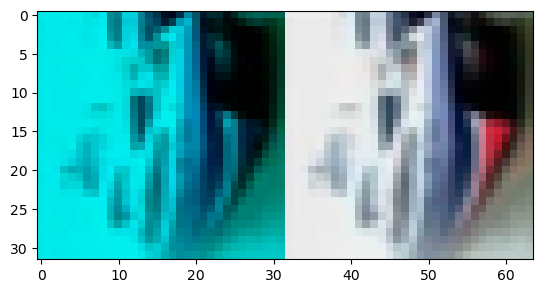

1e torch.Size([1, 32, 32, 3])
Test Loss: 0.0987
1 (32, 32, 3)
2 (32, 32, 3)


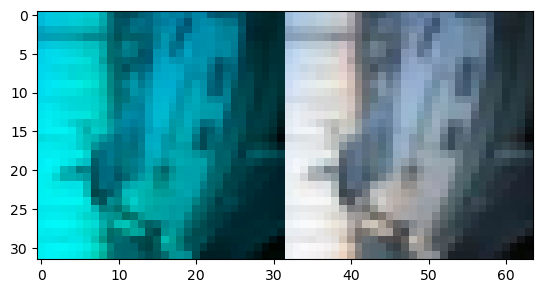

1e torch.Size([1, 32, 32, 3])
Test Loss: 0.1330
1 (32, 32, 3)
2 (32, 32, 3)


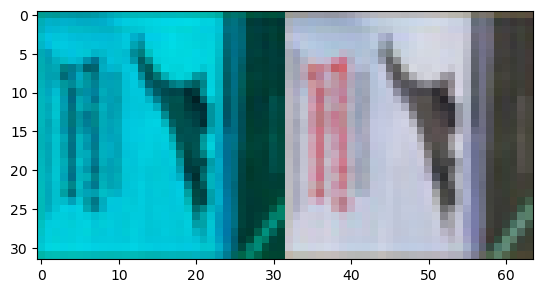

1e torch.Size([1, 32, 32, 3])
Test Loss: 0.0701
1 (32, 32, 3)
2 (32, 32, 3)


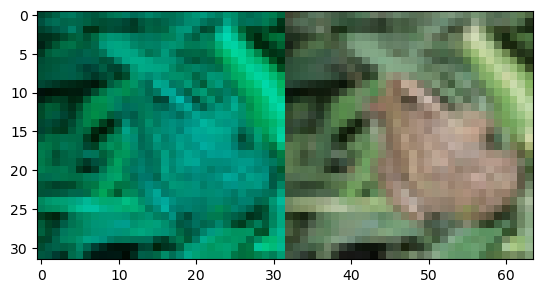

loss,▄▆▅█▅▅▆▅▅▆▃▆▂▂▃▁▃▂▄▂▃▂▂▁▂▂▂▂▁▂▂▂▂▁▂▁▃▃▃▂
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,0.09937
lr,0.001


wandb: Agent Starting Run: ao28jj7j with config:
wandb: 	dim_feed_forward: 256
wandb: 	dimension: 8
wandb: 	dropout_rate: 0.028646495512221648
wandb: 	num_heads: 1
wandb: 	num_layers: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Train sweep with config:  {'dim_feed_forward': 256, 'dimension': 8, 'dropout_rate': 0.028646495512221648, 'num_heads': 1, 'num_layers': 1}
Model para count:  9491 



Files already downloaded and verified
Files already downloaded and verified
Epoch [1/10], Step [4000/4000] Loss: 0.0879, LR: 0.00100
Finished training


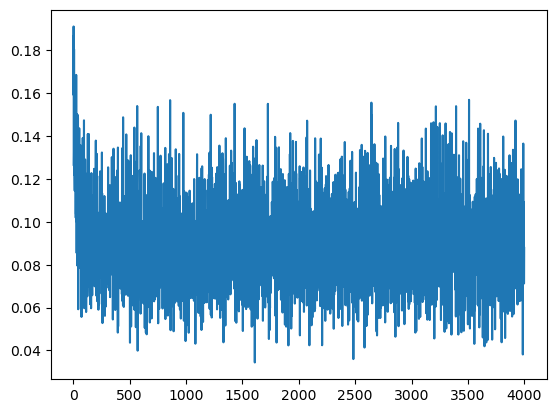

1e torch.Size([1, 32, 32, 3])
Test Loss: 0.0682
1 (32, 32, 3)
2 (32, 32, 3)


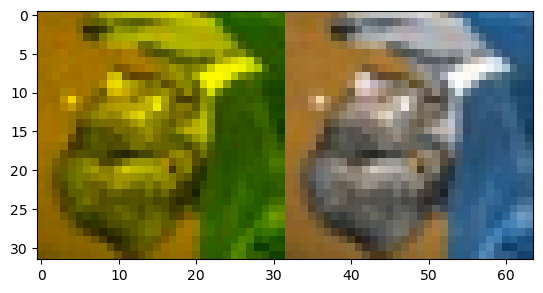

1e torch.Size([1, 32, 32, 3])
Test Loss: 0.1634
1 (32, 32, 3)
2 (32, 32, 3)


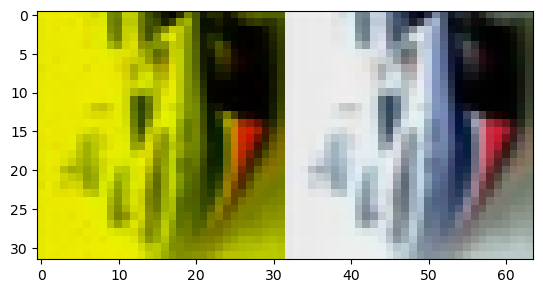

1e torch.Size([1, 32, 32, 3])
Test Loss: 0.1260
1 (32, 32, 3)
2 (32, 32, 3)


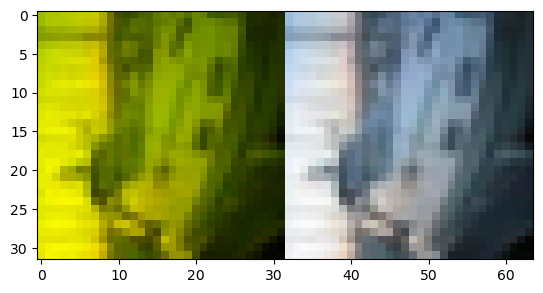

1e torch.Size([1, 32, 32, 3])
Test Loss: 0.1537
1 (32, 32, 3)
2 (32, 32, 3)


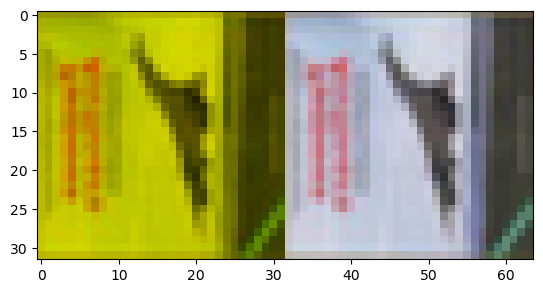

1e torch.Size([1, 32, 32, 3])
Test Loss: 0.0498
1 (32, 32, 3)
2 (32, 32, 3)


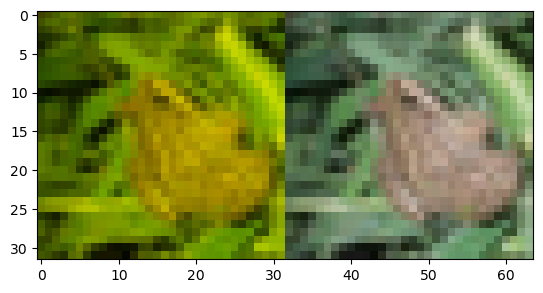

loss,█▅▁▃▄▅▅▂▄▃▅▃▃▅▁▃▅▃▄▃▃▃▆▅▃▃▃▂█▁▂▇▇▆▂▄▆▃▅▆
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,0.08785
lr,0.001


wandb: Agent Starting Run: zk1t6v8g with config:
wandb: 	dim_feed_forward: 64
wandb: 	dimension: 4
wandb: 	dropout_rate: 0.2962133494082104
wandb: 	num_heads: 1
wandb: 	num_layers: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Train sweep with config:  {'dim_feed_forward': 64, 'dimension': 4, 'dropout_rate': 0.2962133494082104, 'num_heads': 1, 'num_layers': 1}
Model para count:  1403 



Files already downloaded and verified
Files already downloaded and verified
Epoch [1/10], Step [4000/4000] Loss: 0.0887, LR: 0.00100
Finished training


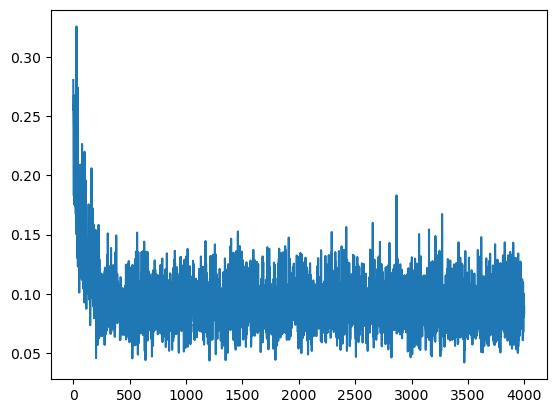

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1e torch.Size([1, 32, 32, 3])
Test Loss: 0.0710
1 (32, 32, 3)
2 (32, 32, 3)


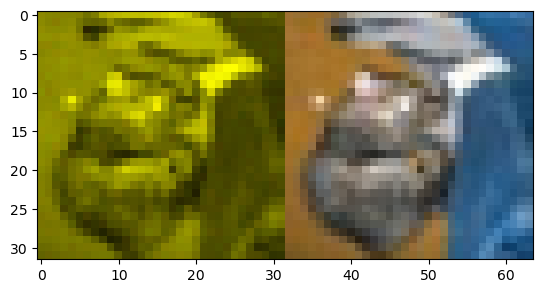

1e torch.Size([1, 32, 32, 3])
Test Loss: 0.1645
1 (32, 32, 3)
2 (32, 32, 3)


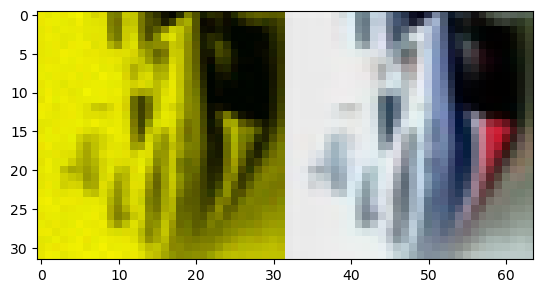

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1e torch.Size([1, 32, 32, 3])
Test Loss: 0.1264
1 (32, 32, 3)
2 (32, 32, 3)


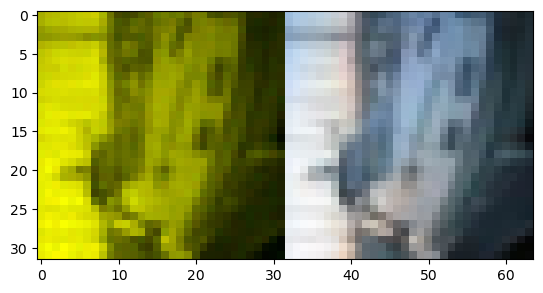

1e torch.Size([1, 32, 32, 3])
Test Loss: 0.1548
1 (32, 32, 3)
2 (32, 32, 3)


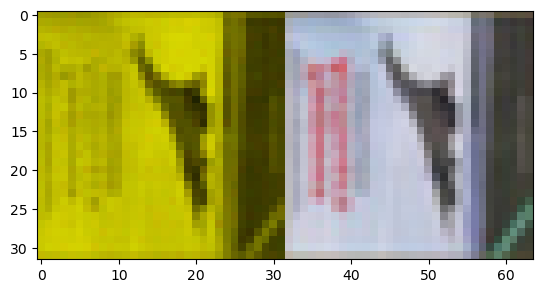

1e torch.Size([1, 32, 32, 3])
Test Loss: 0.0512
1 (32, 32, 3)
2 (32, 32, 3)


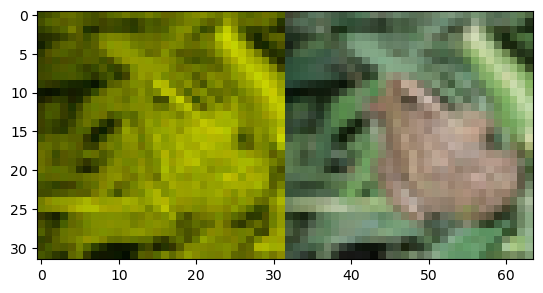

loss,█▄▂▄▃▄▄▃▃▃▄▃▄▃▂▂▄▂▂▃▂▃▂▂▃▃▄▄▂▃▃▄▁▃▂▃▃▃▂▃
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,0.0887
lr,0.001


wandb: Agent Starting Run: 4x1gzd29 with config:
wandb: 	dim_feed_forward: 128
wandb: 	dimension: 8
wandb: 	dropout_rate: 0.424519914243157
wandb: 	num_heads: 2
wandb: 	num_layers: 4
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Train sweep with config:  {'dim_feed_forward': 128, 'dimension': 8, 'dropout_rate': 0.424519914243157, 'num_heads': 2, 'num_layers': 4}
Model para count:  12651 



Files already downloaded and verified
Files already downloaded and verified
Epoch [1/10], Step [4000/4000] Loss: 0.0004, LR: 0.00100
Finished training


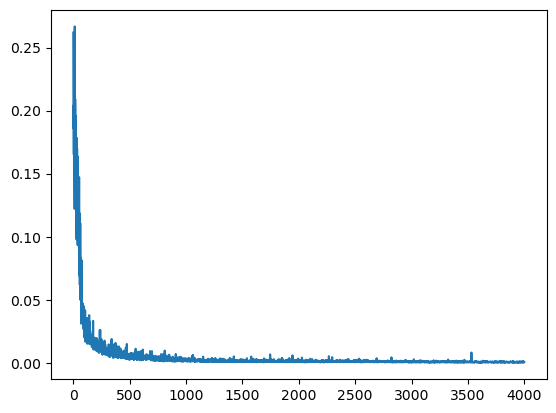

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1e torch.Size([1, 32, 32, 3])
Test Loss: 0.0002
1 (32, 32, 3)
2 (32, 32, 3)


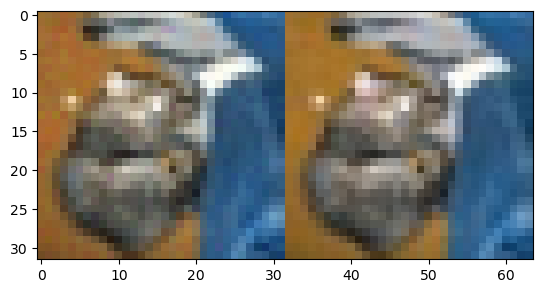

1e torch.Size([1, 32, 32, 3])
Test Loss: 0.0003
1 (32, 32, 3)
2 (32, 32, 3)


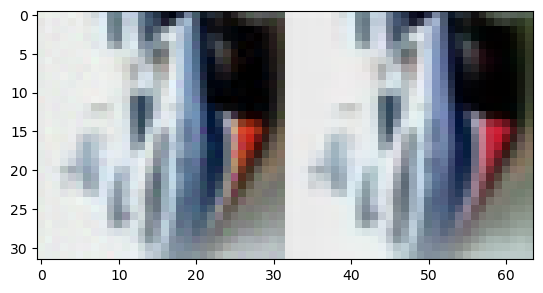

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1e torch.Size([1, 32, 32, 3])
Test Loss: 0.0001
1 (32, 32, 3)
2 (32, 32, 3)


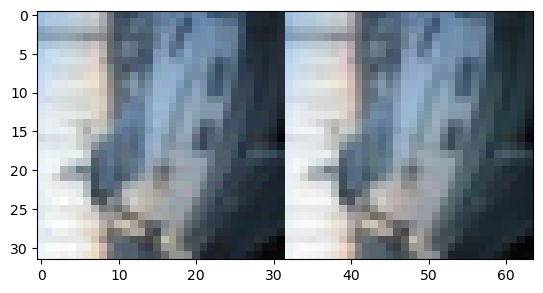

1e torch.Size([1, 32, 32, 3])
Test Loss: 0.0005
1 (32, 32, 3)
2 (32, 32, 3)


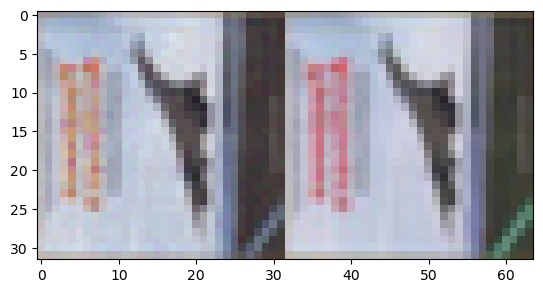

1e torch.Size([1, 32, 32, 3])
Test Loss: 0.0009
1 (32, 32, 3)
2 (32, 32, 3)


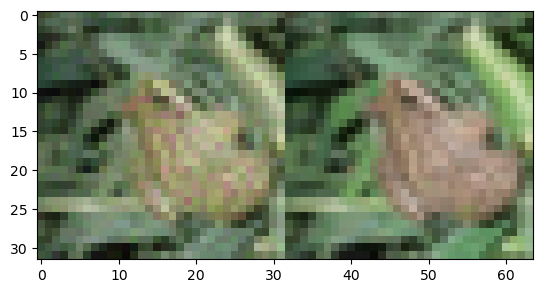

loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,0.00044
lr,0.001


wandb: Agent Starting Run: l37j93vr with config:
wandb: 	dim_feed_forward: 64
wandb: 	dimension: 32
wandb: 	dropout_rate: 0.0921837009469338
wandb: 	num_heads: 1
wandb: 	num_layers: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Train sweep with config:  {'dim_feed_forward': 64, 'dimension': 32, 'dropout_rate': 0.0921837009469338, 'num_heads': 1, 'num_layers': 2}
Model para count:  26915 



Files already downloaded and verified
Files already downloaded and verified
Epoch [1/10], Step [4000/4000] Loss: 0.0000, LR: 0.00100
Finished training


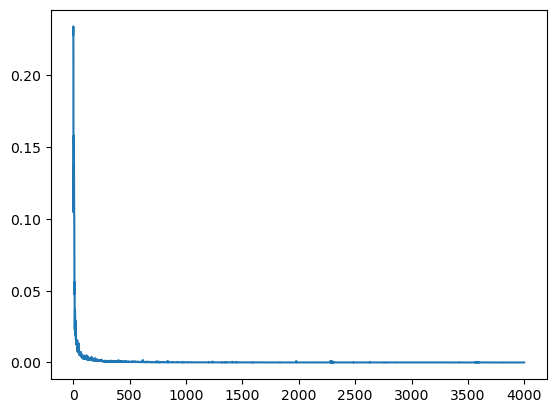

1e torch.Size([1, 32, 32, 3])
Test Loss: 0.0000
1 (32, 32, 3)
2 (32, 32, 3)


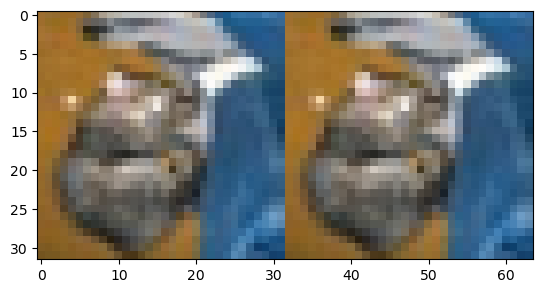

1e torch.Size([1, 32, 32, 3])
Test Loss: 0.0000
1 (32, 32, 3)
2 (32, 32, 3)


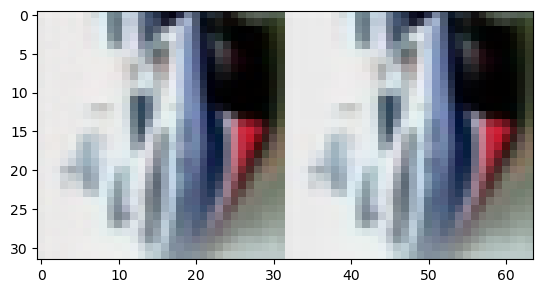

1e torch.Size([1, 32, 32, 3])
Test Loss: 0.0000
1 (32, 32, 3)
2 (32, 32, 3)


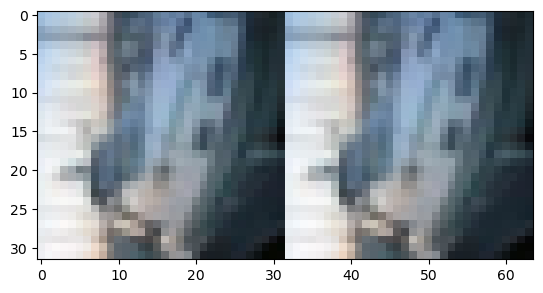

1e torch.Size([1, 32, 32, 3])
Test Loss: 0.0000
1 (32, 32, 3)
2 (32, 32, 3)


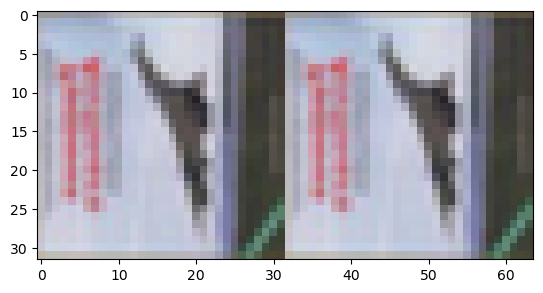

1e torch.Size([1, 32, 32, 3])
Test Loss: 0.0000
1 (32, 32, 3)
2 (32, 32, 3)


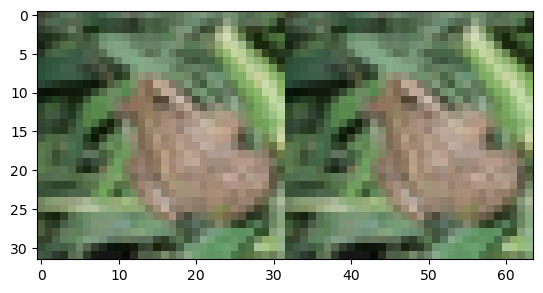

loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,2e-05
lr,0.001


wandb: Agent Starting Run: uqhi9tpr with config:
wandb: 	dim_feed_forward: 4
wandb: 	dimension: 64
wandb: 	dropout_rate: 0.28645674206361876
wandb: 	num_heads: 2
wandb: 	num_layers: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Train sweep with config:  {'dim_feed_forward': 4, 'dimension': 64, 'dropout_rate': 0.28645674206361876, 'num_heads': 2, 'num_layers': 3}
Model para count:  74515 



Files already downloaded and verified
Files already downloaded and verified
Epoch [1/10], Step [4000/4000] Loss: 0.0001, LR: 0.00100
Finished training


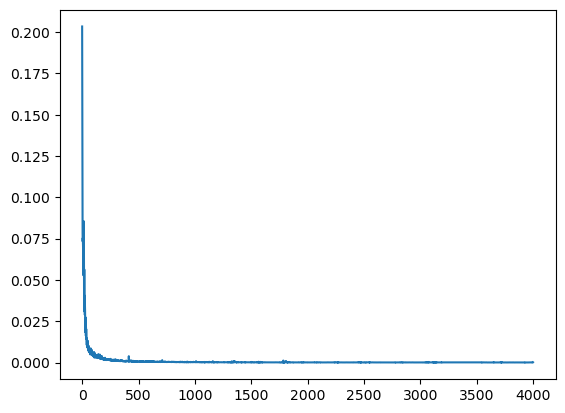

1e torch.Size([1, 32, 32, 3])
Test Loss: 0.0001
1 (32, 32, 3)
2 (32, 32, 3)


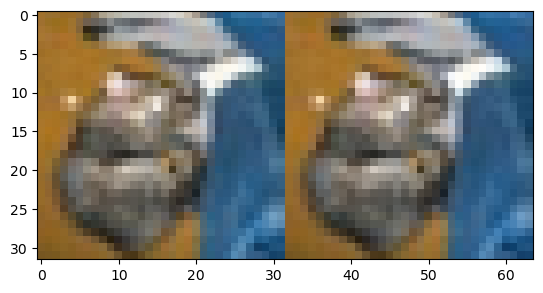

1e torch.Size([1, 32, 32, 3])
Test Loss: 0.0001
1 (32, 32, 3)
2 (32, 32, 3)


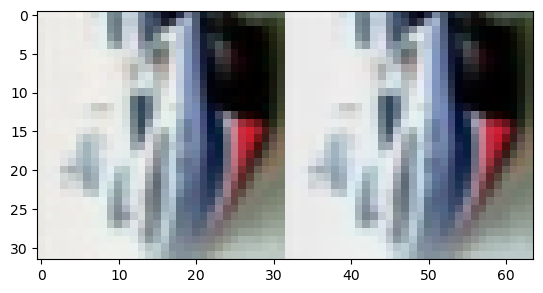

1e torch.Size([1, 32, 32, 3])
Test Loss: 0.0001
1 (32, 32, 3)
2 (32, 32, 3)


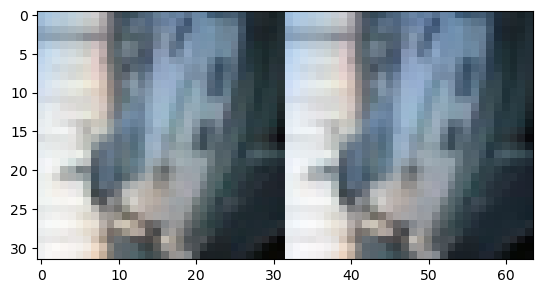

1e torch.Size([1, 32, 32, 3])
Test Loss: 0.0001
1 (32, 32, 3)
2 (32, 32, 3)


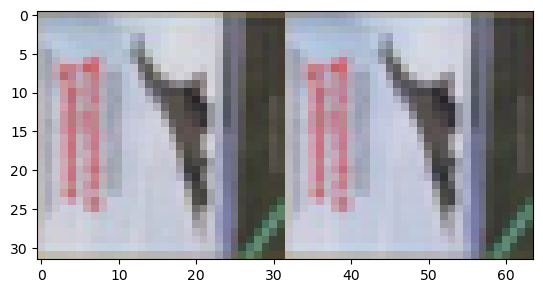

1e torch.Size([1, 32, 32, 3])
Test Loss: 0.0001
1 (32, 32, 3)
2 (32, 32, 3)


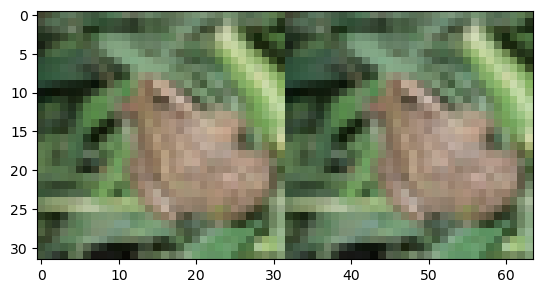

loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,0.00013
lr,0.001


wandb: Agent Starting Run: dfvcg74b with config:
wandb: 	dim_feed_forward: 128
wandb: 	dimension: 128
wandb: 	dropout_rate: 0.38554026790311496
wandb: 	num_heads: 2
wandb: 	num_layers: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Train sweep with config:  {'dim_feed_forward': 128, 'dimension': 128, 'dropout_rate': 0.38554026790311496, 'num_heads': 2, 'num_layers': 2}
Model para count:  316163 



Files already downloaded and verified
Files already downloaded and verified
Epoch [1/10], Step [4000/4000] Loss: 0.0001, LR: 0.00100
Finished training


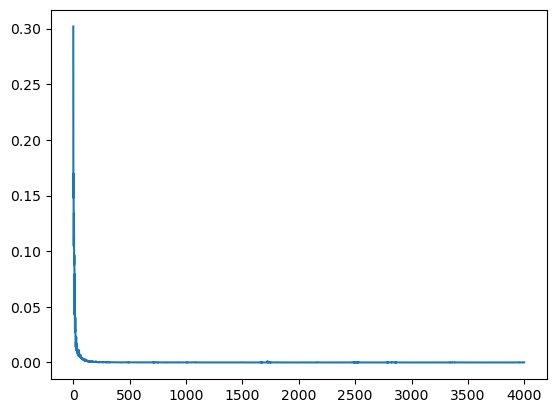

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1e torch.Size([1, 32, 32, 3])
Test Loss: 0.0001
1 (32, 32, 3)
2 (32, 32, 3)


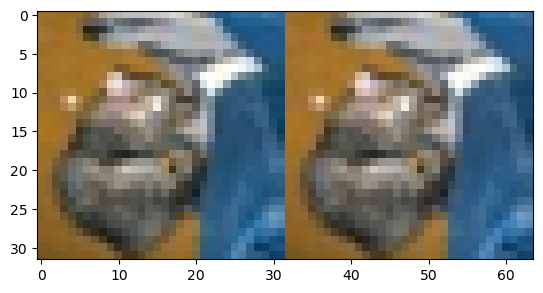

1e torch.Size([1, 32, 32, 3])
Test Loss: 0.0001
1 (32, 32, 3)
2 (32, 32, 3)


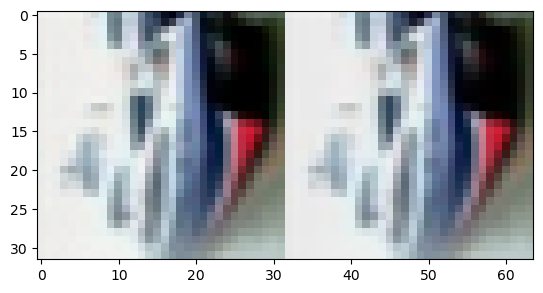

1e torch.Size([1, 32, 32, 3])
Test Loss: 0.0001
1 (32, 32, 3)
2 (32, 32, 3)


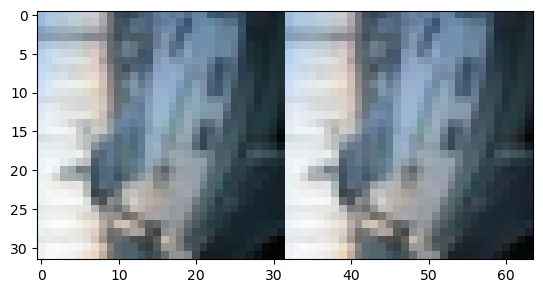

1e torch.Size([1, 32, 32, 3])
Test Loss: 0.0001
1 (32, 32, 3)
2 (32, 32, 3)


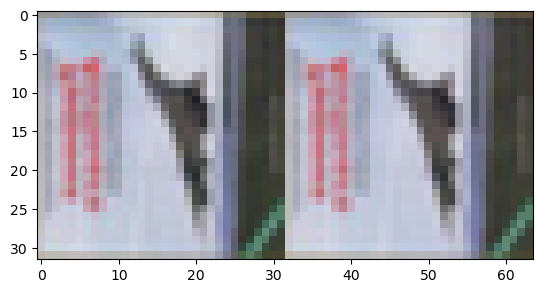

1e torch.Size([1, 32, 32, 3])
Test Loss: 0.0001
1 (32, 32, 3)
2 (32, 32, 3)


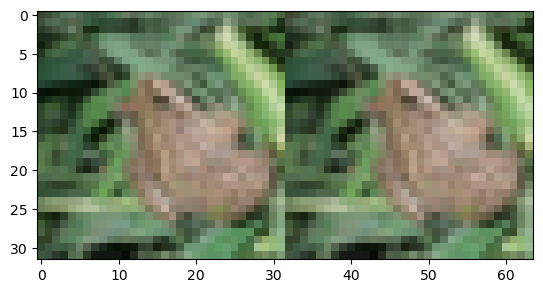

loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,7e-05
lr,0.001


wandb: Agent Starting Run: x0kgpwnf with config:
wandb: 	dim_feed_forward: 4
wandb: 	dimension: 8
wandb: 	dropout_rate: 0.38403959044874
wandb: 	num_heads: 4
wandb: 	num_layers: 5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Train sweep with config:  {'dim_feed_forward': 4, 'dimension': 8, 'dropout_rate': 0.38403959044874, 'num_heads': 4, 'num_layers': 5}
Model para count:  2507 



Files already downloaded and verified
Files already downloaded and verified
Epoch [1/10], Step [4000/4000] Loss: 0.0007, LR: 0.00100
Finished training


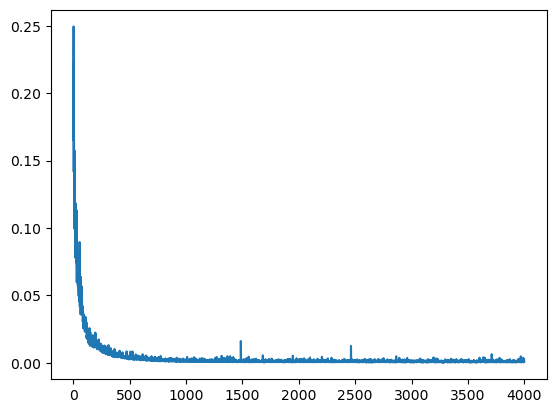

1e torch.Size([1, 32, 32, 3])
Test Loss: 0.0003
1 (32, 32, 3)
2 (32, 32, 3)


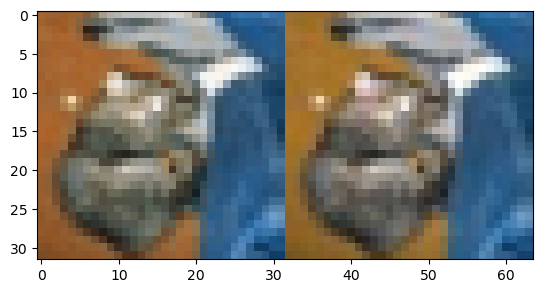

1e torch.Size([1, 32, 32, 3])
Test Loss: 0.0005
1 (32, 32, 3)
2 (32, 32, 3)


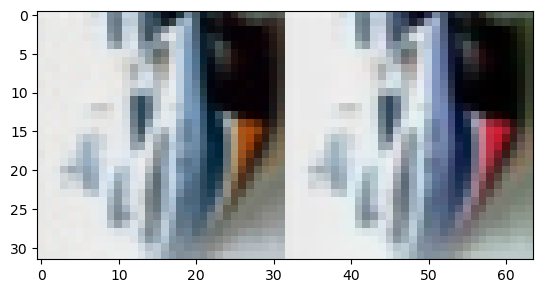

1e torch.Size([1, 32, 32, 3])
Test Loss: 0.0001
1 (32, 32, 3)
2 (32, 32, 3)


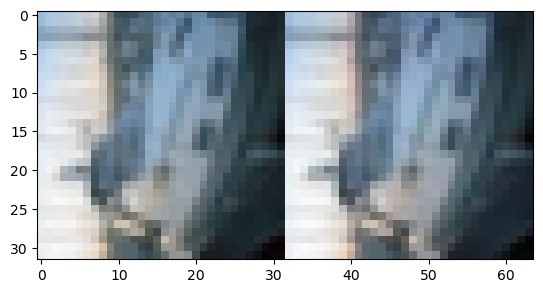

1e torch.Size([1, 32, 32, 3])
Test Loss: 0.0008
1 (32, 32, 3)
2 (32, 32, 3)


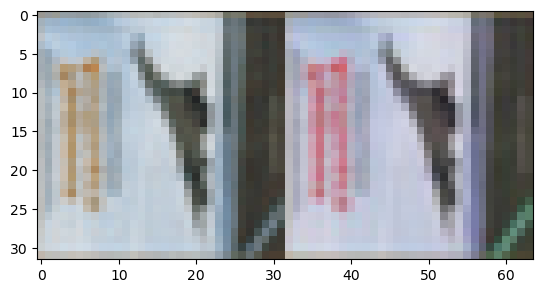

1e torch.Size([1, 32, 32, 3])
Test Loss: 0.0019
1 (32, 32, 3)
2 (32, 32, 3)


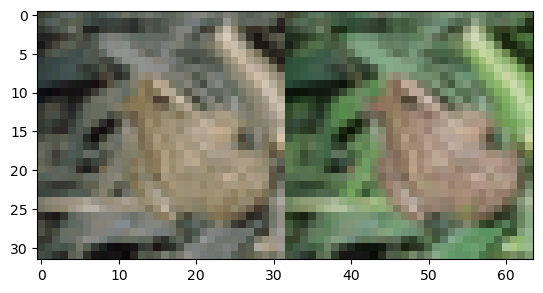

loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,0.00069
lr,0.001


wandb: Agent Starting Run: 6gybz3ys with config:
wandb: 	dim_feed_forward: 32
wandb: 	dimension: 16
wandb: 	dropout_rate: 0.10448324897128164
wandb: 	num_heads: 2
wandb: 	num_layers: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: Ctrl + C detected. Stopping sweep.


Traceback (most recent call last):
  File "/data/vision/polina/projects/wmh/dhollidt/conda/envs/nerfstudio3/lib/python3.8/site-packages/wandb/sdk/wandb_init.py", line 1133, in init
    run = wi.init()
  File "/data/vision/polina/projects/wmh/dhollidt/conda/envs/nerfstudio3/lib/python3.8/site-packages/wandb/sdk/wandb_init.py", line 787, in init
    run_start_result = run_start_handle.wait(timeout=30)
  File "/data/vision/polina/projects/wmh/dhollidt/conda/envs/nerfstudio3/lib/python3.8/site-packages/wandb/sdk/lib/mailbox.py", line 273, in wait
    found, abandoned = self._slot._get_and_clear(timeout=wait_timeout)
  File "/data/vision/polina/projects/wmh/dhollidt/conda/envs/nerfstudio3/lib/python3.8/site-packages/wandb/sdk/lib/mailbox.py", line 120, in _get_and_clear
    if self._wait(timeout=timeout):
  File "/data/vision/polina/projects/wmh/dhollidt/conda/envs/nerfstudio3/lib/python3.8/site-packages/wandb/sdk/lib/mailbox.py", line 116, in _wait
    return self._event.wait(timeout=timeo

Problem at: /tmp/ipykernel_669/3099458380.py 6 train_sweep


wandb: ERROR Abnormal program exit


In [4]:
wandb.agent(sweep_id, function=train_sweep, count=30)

In [ ]:
first_batch = next(iter(trainloader))
x, labels = first_batch
x = x.permute(0, 3, 2, 1)
plt.imshow(x[0])
plt.show()

x = x.reshape(x.shape[0],-1, 3)

x = x.reshape(x.shape[0], 32, 32, 3)



plt.imshow(x[0])

plt.show()

In [ ]:
encoder_layer = torch.nn.TransformerEncoderLayer(
            4, 2, 32, 0.1, batch_first=True
        )

out = encoder_layer(torch.rand(8, 32, 4))
print(out.shape)

transformer = torch.nn.TransformerEncoder(encoder_layer, 2)
out = transformer(torch.rand(8, 32, 4))
print(out.shape)